In [118]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn



### **read data**


In [119]:
df=pd.read_csv("/content/drive/MyDrive/archive/Tweets.csv",delimiter=',',encoding='utf-8')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

EDA

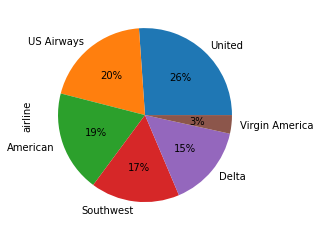

In [ ]:
df.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

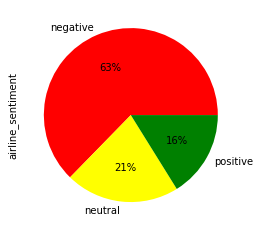

In [ ]:
df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


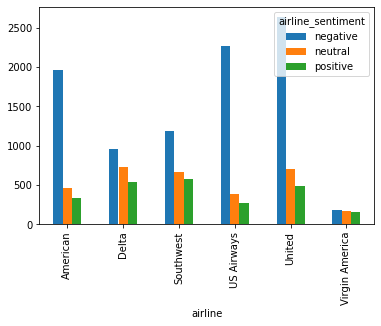

In [ ]:
airline_sentiment = df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
print(airline_sentiment)
airline_sentiment.plot(kind='bar')

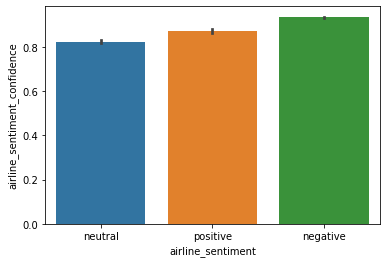

In [ ]:
sn.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=df)

## data cleaning

In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [121]:
df.fillna(0,inplace=True)

In [122]:
df.isnull().mean()*100

tweet_id                        0.0
airline_sentiment               0.0
airline_sentiment_confidence    0.0
negativereason                  0.0
negativereason_confidence       0.0
airline                         0.0
airline_sentiment_gold          0.0
name                            0.0
negativereason_gold             0.0
retweet_count                   0.0
text                            0.0
tweet_coord                     0.0
tweet_created                   0.0
tweet_location                  0.0
user_timezone                   0.0
dtype: float64

In [123]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [124]:
features = df.iloc[:, 10].values
labels = df.iloc[:, 1].values

In [ ]:
from nltk.corpus import stopwords




In [125]:
processed_features = []

for sentence in range(0, len(features)):
    
    features[sentence]=features[sentence].lower()
    
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    

    processed_features.append(processed_feature)

In [126]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vectorizer=Tokenizer(num_words=2500)
vectorizer.fit_on_texts(processed_features)
processed_features =vectorizer.texts_to_sequences(processed_features)

processed_features = pad_sequences(processed_features, padding='post', maxlen=50)

In [ ]:
processed_features

array([[ 77,  48, 221, ...,   0,   0,   0],
       [ 77, 546,   3, ...,   0,   0,   0],
       [ 77, 197,  96, ...,   0,   0,   0],
       ...,
       [ 11,  72, 648, ...,   0,   0,   0],
       [ 11,   3,  22, ...,   0,   0,   0],
       [ 11,  30,  22, ...,   0,   0,   0]], dtype=int32)

In [127]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout,Conv1D,MaxPooling1D,Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall

labels=pd.get_dummies(labels)
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.3, random_state=0)
X_train,x_val, y_train, y_val =train_test_split(X_train, y_train,test_size=0.1,random_state=0)



In [ ]:
print("train data shape:",X_train.shape,y_train.shape)
print("test data shape:",X_test.shape,y_test.shape)
print("validation data shape:",x_val.shape,y_val.shape)
input_length=X_train.shape[1]
print(input_length)


train data shape: (9223, 50) (9223, 3)
test data shape: (4392, 50) (4392, 3)
validation data shape: (1025, 50) (1025, 3)
50


In [ ]:
from tqdm import tqdm
embedding_vector = {}
f = open('/content/drive/MyDrive/glove.6B.50d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:04, 84891.13it/s]


In [ ]:
vocab_size = len(vectorizer.word_index)+1
embedding_matrix = np.zeros((vocab_size,50))
for word,i in tqdm(vectorizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 15084/15084 [00:00<00:00, 510900.73it/s]


In [ ]:
len(vectorizer.word_index)+1

15085

## Build LSTM Model

sgd = SGD(learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [128]:

opt=Adam(learning_rate=3.0351e-07)

In [131]:
max_features=2500
embed_dim=128
model=Sequential()
model.add(Embedding(vocab_size,50,weights = [embedding_matrix],input_length=50,trainable = False))
model.add(LSTM(196,dropout=0.6))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
print(model.summary())




Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 50)            754250    
                                                                 
 lstm_11 (LSTM)              (None, 196)               193648    
                                                                 
 dropout_9 (Dropout)         (None, 196)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 591       
                                                                 
Total params: 948,489
Trainable params: 194,239
Non-trainable params: 754,250
_________________________________________________________________
None


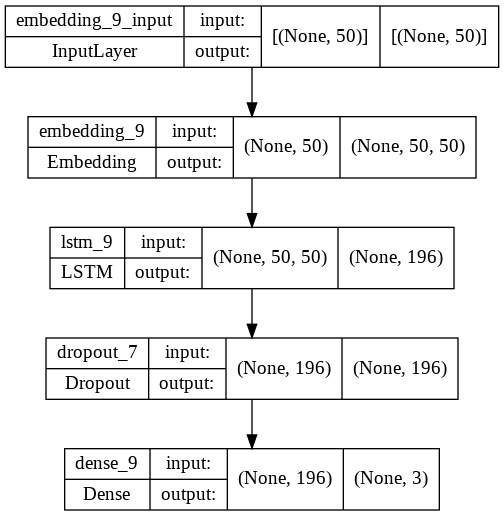

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes = True)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [133]:
model.fit(X_train,y_train,epochs=200,validation_data=(x_val,y_val))



Epoch 1/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2846 - accuracy: 0.8943 - val_loss: 0.7621 - val_accuracy: 0.7668
Epoch 2/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2859 - accuracy: 0.8942 - val_loss: 0.7525 - val_accuracy: 0.7649
Epoch 3/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2804 - accuracy: 0.8991 - val_loss: 0.7510 - val_accuracy: 0.7580
Epoch 4/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2772 - accuracy: 0.9007 - val_loss: 0.7642 - val_accuracy: 0.7649
Epoch 5/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2937 - accuracy: 0.8908 - val_loss: 0.7561 - val_accuracy: 0.7629
Epoch 6/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2804 - accuracy: 0.8943 - val_loss: 0.7970 - val_accuracy: 0.7776
Epoch 7/200
289/289 [==============================] - 2s 7ms/step - loss: 0.2898 - accuracy: 0.8929 - val_loss: 0.7461 - val_accuracy: 0.7785

In [ ]:
model.evaluate(X_test,y_test)

138/138 [==============================] - 1s 4ms/step - loss: 1.5672 - accuracy: 0.7605


[1.5671613216400146, 0.7604736089706421]

In [ ]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Text(51.0, 0.5, 'Predicted label')

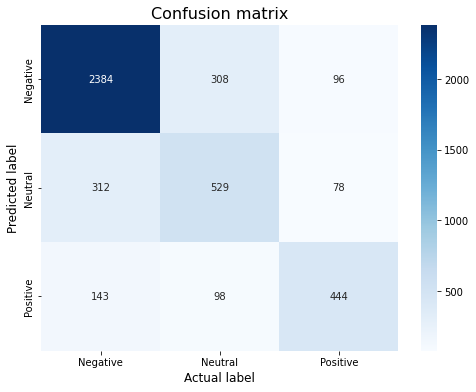

In [ ]:
y_pred=model.predict(X_test)
sentiment_classes = ['Negative', 'Neutral', 'Positive']
cm=confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)